In [1]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

from matplotlib import pyplot as plt
from kerasutils import plot_training_data, describe_model
from kerasutils import PermaDropout

from lstm_textgen import TextToTrainingData


/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
print(os.getcwd())

/home/ubuntu/jdm/cnn/Transform-CNNs


In [3]:
# load ascii text and covert to lowercase
#path = '../../data/'
#filename = "ml.txt"
path = './'
# No replies in this one
filename = '@dril.2018-04-22.txt'
raw_text = open(path+filename).read()
raw_text = raw_text.lower()

print(len(raw_text))

239840


In [4]:
text_to_train = TextToTrainingData(raw_text)
print("Total Characters: ", text_to_train.n_chars)
print("Total Vocab: ", text_to_train.n_vocab)
print(text_to_train.chars)

Total Characters:  239840
Total Vocab:  77
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'ê', '̶', '—', '…', '™', '▀', '▄', '█', '▐', '░', '⸻', '》']


In [5]:
seq_length=30
X,y = text_to_train.get_training_data(seq_length=seq_length)

print("Total patterns: ", len(X))
print(X.shape)
print(y.shape)
input_shape = X[0,:,:].shape
print('Input shape: {0}'.format(input_shape))

Total patterns:  239810
(239810, 30, 1)
(239810, 77)
Input shape: (30, 1)


In [15]:
# define the LSTM model
n_vocab = text_to_train.n_vocab

model = Sequential()
model.add(LSTM(n_vocab*4, 
               input_shape=input_shape, 
               return_sequences=True))
model.add(PermaDropout(0.3))
model.add(LSTM(n_vocab*2))
model.add(PermaDropout(0.3))
#model.add(Dense(n_vocab*2))
#model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Dense(n_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
#print(X.shape)
#print(y.shape)
nsubset = 150000

x_short = X[0:nsubset,:,:]
y_short = y[0:nsubset,:]
# x_short = X 
# y_short = y

#x_train, x_test, y_train, y_test = train_test_split(x_short, y_short, test_size=0.5)
x_train = X[0:(nsubset),:,:]
y_train = y[0:(nsubset),:]
x_test = X[nsubset:int(1.1*nsubset),:,:]
y_test = y[nsubset:int(1.1*nsubset),:]


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(150000, 30, 1)
(15000, 30, 1)
(150000, 77)
(15000, 77)


In [17]:
callbacks_list = None

In [93]:
# define the checkpoint
filepath=filename+".{epoch:02d}-{loss:.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [23]:
batch_size=512
n_epochs=10

h=model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, 
            validation_data=(x_test, y_test),
            callbacks=callbacks_list)

Train on 150000 samples, validate on 15000 samples
Epoch 1/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.7342 - acc: 0.2399 - val_loss: 2.7677 - val_acc: 0.2349
Epoch 2/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.7179 - acc: 0.2430 - val_loss: 2.7479 - val_acc: 0.2401
Epoch 3/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.7023 - acc: 0.2459 - val_loss: 2.7338 - val_acc: 0.2415
Epoch 4/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.6868 - acc: 0.2482 - val_loss: 2.7285 - val_acc: 0.2417
Epoch 5/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.6699 - acc: 0.2519 - val_loss: 2.7225 - val_acc: 0.2433
Epoch 6/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.6549 - acc: 0.2549 - val_loss: 2.7080 - val_acc: 0.2475
Epoch 7/10
150000/150000 [==============================] - 44s 296us/step - loss: 2.6376 - acc: 0.2578

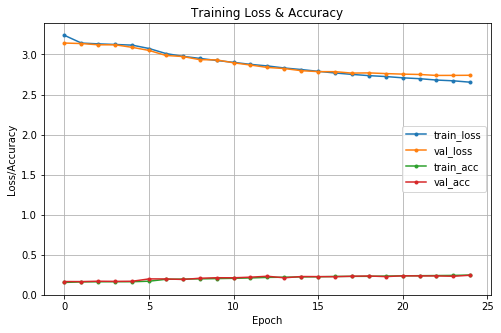

In [12]:
plot_training_data(h)

In [16]:
model.layers[1].rate = 0.4
model.layers[3].rate = 0.4

In [ ]:
prompt = text_to_train.prompt_input('this that or the other ', input_shape[0])
text = text_to_train.generate_text(model=model, 
                                   generated_seq_length=280, 
                                   prompt=prompt)
print(text)
#print(len(text))

In [ ]:
inp = 'blah'

while len(inp) > 0:
    inp = input('?')
    if len(inp) > input_shape[0]:
        inp = inp[-input_shape[0]:]
    prompt = text_to_train.prompt_input(inp, input_shape[0])
    text = text_to_train.generate_text(model=model, 
                                       generated_seq_length=180, 
                                       prompt=prompt)
    print(text)

?One thing and another
         One thing and another the seet the poe to thet the can to the toil the can the bon the cane the cocke to the toil the tirl the tiin th the canl to the the thet the con to the thet the toee the totl the
?toilet is not going to get it done
et is not going to get it done the con the conl the soul to me the coa the tool the soen the torl teet the gare the cat the tee teet the tare the con the colk the gat the coo the toil to the thet the terl the t


In [175]:
describe_model(model)

Layer 0: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 1)
    output=(None, 30, 308)
    act=<function tanh at 0x7f330a7188c8>
Layer 1: <class 'keras.layers.core.Dropout'>
    input=(None, 30, 308)
    output=(None, 30, 308)
    rate=0.15
Layer 2: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 308)
    output=(None, 154)
    act=<function tanh at 0x7f330a7188c8>
Layer 3: <class 'keras.layers.core.Dropout'>
    input=(None, 154)
    output=(None, 154)
    rate=0.15
Layer 4: <class 'keras.layers.core.Dense'>
    input=(None, 154)
    output=(None, 77)
    act=<function softmax at 0x7f330a718598>


In [13]:
describe_model(model)

Layer 0: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 1)
    output=(None, 30, 308)
    act=<function relu at 0x7f394bb4cea0>
Layer 1: <class 'keras.layers.core.Dropout'>
    input=(None, 30, 308)
    output=(None, 30, 308)
    rate=0.2
Layer 2: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 308)
    output=(None, 154)
    act=<function relu at 0x7f394bb4cea0>
Layer 3: <class 'keras.layers.core.Dropout'>
    input=(None, 154)
    output=(None, 154)
    rate=0.2
Layer 4: <class 'keras.layers.core.Dense'>
    input=(None, 154)
    output=(None, 77)
    act=<function softmax at 0x7f394bb4cbf8>


In [176]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(x_test, batch_size=batch_size)
target_names = chars
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          
       0.62      0.53      0.57       529
                  0.70      0.85      0.77      7497
          !       0.82      0.39      0.53        36
          "       0.47      0.50      0.49       253
          #       0.62      0.53      0.57        15
          $       0.60      0.25      0.35        12
          %       0.00      0.00      0.00         4
          &       0.33      0.11      0.16        19
          '       0.79      0.28      0.41        40
          (       0.67      0.13      0.22        30
          )       1.00      0.14      0.25        35
          *       1.00      0.50      0.67         2
          +       0.52      0.30      0.38       225
          ,       0.35      0.15      0.21        39
          -       0.75      0.47      0.58       374
          .       0.98      0.95      0.96       226
          /       0.58      0.76      0.66       105
          0     

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 67, does not match size of target_names, 77
  .format(len(labels), len(target_names))
/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [150]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(x_train, batch_size=batch_size)
target_names = chars
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          
       0.79      0.48      0.59      1196
                  0.68      0.87      0.76     16696
          !       0.83      0.57      0.68        70
          "       0.73      0.44      0.55       626
          #       0.91      0.28      0.43        36
          $       1.00      0.20      0.33        35
          %       0.67      0.15      0.25        13
          &       0.58      0.18      0.28        38
          '       0.92      0.15      0.26        72
          (       0.60      0.06      0.12        47
          )       0.85      0.19      0.31        58
          *       0.00      0.00      0.00         2
          +       0.77      0.24      0.37       478
          ,       0.82      0.16      0.26        90
          -       0.83      0.45      0.59       833
          .       0.99      0.96      0.98       521
          /       0.65      0.77      0.71       275
          0     

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 73, does not match size of target_names, 77
  .format(len(labels), len(target_names))
/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
# load the network weights for the final model
#weights_file = "ml.txt.10-2.8160.hdf5"
weights_file = "@dril.2018-04-22.txt.16-0.2807.hdf5"
#model.load_weights(weights_file)
model = load_model(weights_file)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
print(255*x_train[100,:,:])
print(255*x_train[101,:,:])

[[142.4025974 ]
 [125.84415584]
 [165.58441558]
 [172.20779221]
 [192.07792208]
 [185.45454545]
 [  3.31168831]
 [129.15584416]
 [205.32467532]
 [  3.31168831]
 [135.77922078]
 [182.14285714]
 [ 49.67532468]
 [  3.31168831]
 [139.09090909]
 [195.38961039]
 [152.33766234]
 [162.27272727]
 [  3.31168831]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [125.84415584]
 [192.07792208]
 [185.45454545]
 [188.76623377]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [175.51948052]]
[[125.84415584]
 [165.58441558]
 [172.20779221]
 [192.07792208]
 [185.45454545]
 [  3.31168831]
 [129.15584416]
 [205.32467532]
 [  3.31168831]
 [135.77922078]
 [182.14285714]
 [ 49.67532468]
 [  3.31168831]
 [139.09090909]
 [195.38961039]
 [152.33766234]
 [162.27272727]
 [  3.31168831]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [125.84415584]
 [192.07792208]
 [185.45454545]
 [188.76623377]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [175.51948052]
 [172.20779221]]
